In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import heapq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import nltk
import keras
from keras.models import Sequential 
from keras.preprocessing.text import one_hot
from keras.layers import Dense,Dropout,LSTM,Embedding
from keras.preprocessing.sequence import pad_sequences

In [171]:
data = pd.read_csv('../input/twitter-airline-sentiment/Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [172]:
len(data)

14640

In [173]:
data.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

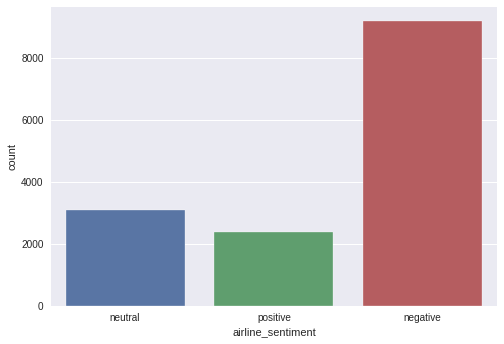

In [174]:
plt.style.use('seaborn')
sns.countplot(data=data,x='airline_sentiment')

In [175]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

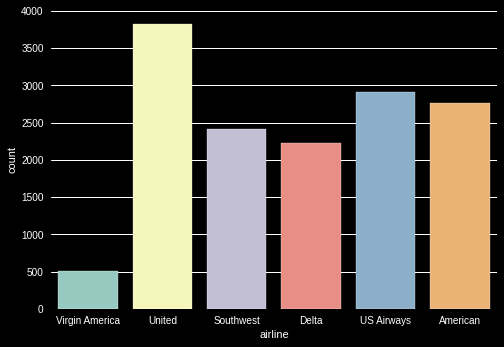

In [176]:
plt.style.use('dark_background')
sns.countplot(data=data,x='airline')

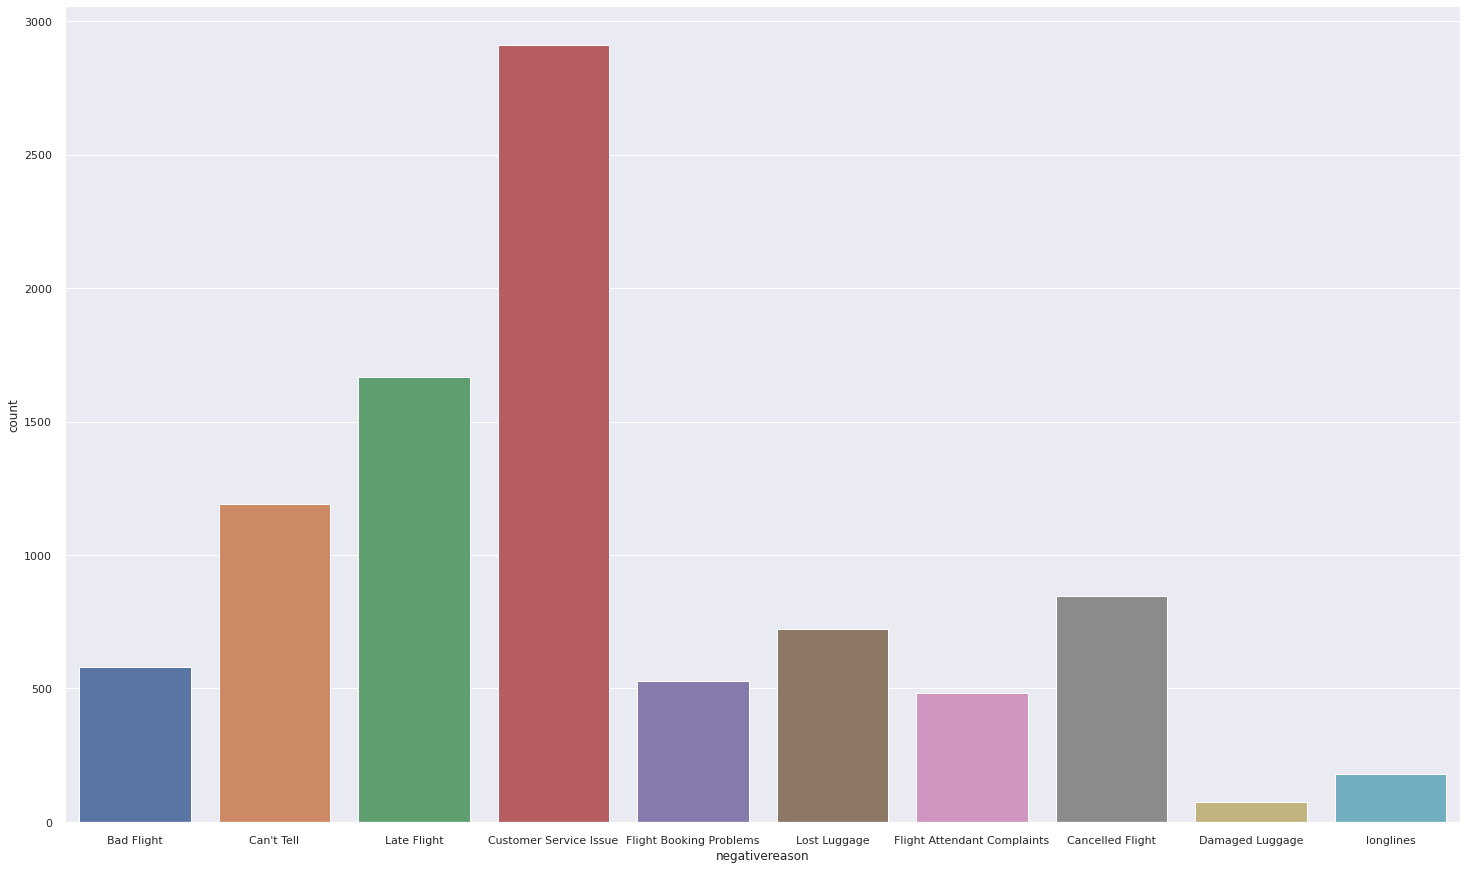

In [177]:
sns.set(rc={'figure.figsize':(25,15)})
sns.countplot(data=data,x='negativereason')

In [178]:
data = data[['text','airline_sentiment']]
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [179]:
data['text'][5]

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"

In [180]:
def remove_stopwords(inp_text):
    stop = nltk.corpus.stopwords.words('english')
    punc = string.punctuation
    stop.append(punc)
    whitelist = ["n't", "not", "no"]
    clean_words = []
    words = nltk.word_tokenize(inp_text)
    for word in words:
        if word not in stop or word not in whitelist and len(word)>1:
            clean_words.append(word)
    return " ".join(clean_words)

In [181]:
remove_stopwords(data['text'][5])

"@ VirginAmerica seriously would pay $ 30 flight for seats that did n't have this playing . it 's really the only bad thing about flying VA"

In [182]:
def remove_mentions(input_text):
        return re.sub(r'@ \w+', '', input_text)

In [183]:
data.text = data.text.apply(remove_stopwords).apply(remove_mentions)
data.head()

,text,airline_sentiment
0,What said .,neutral
1,plus you 've added commercials to the experie...,positive
2,I did n't today ... Must mean I need to take ...,neutral
3,it 's really aggressive to blast obnoxious ``...,negative
4,and it 's really big bad thing about it,negative


In [184]:
word2count = {}

for i in range(len(data['text'])):
    words = nltk.word_tokenize(data['text'][i])
    
    for word in words:
        if word not in word2count.keys():
            word2count[word] = 1
        else:
            word2count[word] += 1

In [185]:
word2count

{'What': 256,
 'said': 172,
 '.': 13633,
 'plus': 45,
 'you': 3921,
 "'ve": 467,
 'added': 20,
 'commercials': 5,
 'to': 8590,
 'the': 5794,
 'experience': 196,
 '...': 1051,
 'tacky': 1,
 'I': 6347,
 'did': 474,
 "n't": 2070,
 'today': 405,
 'Must': 8,
 'mean': 54,
 'need': 473,
 'take': 261,
 'another': 234,
 'trip': 204,
 '!': 5312,
 'it': 2079,
 "'s": 1494,
 'really': 228,
 'aggressive': 3,
 'blast': 2,
 'obnoxious': 2,
 '``': 461,
 'entertainment': 23,
 "''": 464,
 'in': 2478,
 'your': 1550,
 'guests': 4,
 "'": 79,
 'faces': 3,
 '&': 823,
 'amp': 683,
 ';': 956,
 'they': 619,
 'have': 1651,
 'little': 67,
 'recourse': 5,
 'and': 3573,
 'big': 53,
 'bad': 160,
 'thing': 69,
 'about': 493,
 'seriously': 49,
 'would': 559,
 'pay': 126,
 '$': 432,
 '30': 112,
 'flight': 3157,
 'for': 3953,
 'seats': 198,
 'that': 1576,
 'this': 1172,
 'playing': 8,
 'only': 289,
 'flying': 289,
 'VA': 7,
 'yes': 162,
 ',': 4156,
 'nearly': 13,
 'every': 93,
 'time': 747,
 'fly': 362,
 'VX': 7,
 '“': 1

In [186]:
print("Vocabluray of our corpus is: {}".format(len(word2count)))

Vocabluray of our corpus is: 19230


In [187]:
word_freq = heapq.nlargest(10000,word2count,key=word2count.get)
word_freq[:15]

['.',
 'to',
 'I',
 'the',
 '!',
 '?',
 ',',
 'for',
 'you',
 'on',
 '#',
 'and',
 'flight',
 'my',
 'is']

In [188]:
vocab_size = len(word_freq)

In [189]:
onehot_text = []
for sentences in data['text']:
    Z = one_hot(sentences,vocab_size)
    onehot_text.append(Z)

In [190]:
onehot_text[:5]

[[462, 3989],
 [7639, 659, 7656, 6838, 1319, 3552, 4902, 6536, 927],
 [721, 6501, 5200, 6967, 7779, 7977, 721, 2611, 3552, 8159, 4812, 8667],
 [2516,
  1705,
  5628,
  3098,
  3552,
  7665,
  2992,
  6580,
  7628,
  1376,
  3197,
  878,
  9243,
  9600,
  469,
  7409,
  639,
  7815,
  7882],
 [4733, 2516, 1705, 5628, 4610, 8099, 5907, 1374, 2516]]

In [191]:
length = 20
embedded_sents = pad_sequences(onehot_text,padding='pre',maxlen=length)

In [192]:
embedded_sents[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  462, 3989],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        7639,  659, 7656, 6838, 1319, 3552, 4902, 6536,  927],
       [   0,    0,    0,    0,    0,    0,    0,    0,  721, 6501, 5200,
        6967, 7779, 7977,  721, 2611, 3552, 8159, 4812, 8667],
       [   0, 2516, 1705, 5628, 3098, 3552, 7665, 2992, 6580, 7628, 1376,
        3197,  878, 9243, 9600,  469, 7409,  639, 7815, 7882],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        4733, 2516, 1705, 5628, 4610, 8099, 5907, 1374, 2516]],
      dtype=int32)

In [193]:
labels = data['airline_sentiment']
labels

0         neutral
1        positive
2         neutral
3        negative
4        negative
           ...   
14635    positive
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 14640, dtype: object

In [194]:
lb = LabelBinarizer()

In [195]:
labels = lb.fit_transform(labels)
labels

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [196]:
X = embedded_sents
y = labels

In [197]:
X = np.asarray(X)
y = np.asarray(y)

In [198]:
len(X)

14640

In [199]:
len(y)

14640

In [200]:
X_train = X[:13000]
y_train = y[:13000]

In [201]:
X_test = X[13000:]
y_test = y[13000:]

In [202]:
X_train.shape

(13000, 20)

In [203]:
y_train.shape

(13000, 3)

In [204]:
X_test.shape

(1640, 20)

In [205]:
y_test.shape

(1640, 3)

In [206]:
X_training,X_valid,y_training,y_valid = train_test_split(X_train,y_train,test_size=0.2)

In [207]:
X_training.shape

(10400, 20)

In [208]:
X_valid.shape

(2600, 20)

In [209]:
model = Sequential()

Traditional Deep Learning Model

In [213]:
model.add(Dense(512,activation='relu',input_shape=(20,)))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))

In [214]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [215]:
history = model.fit(X_training,y_training,validation_data=(X_valid,y_valid),epochs=100,batch_size=64)

Train on 10400 samples, validate on 2600 samples
Epoch 1/100
10400/10400 [==============================] - 2s 159us/step - loss: 0.5588 - accuracy: 0.7329 - val_loss: 0.5380 - val_accuracy: 0.7544
Epoch 2/100
10400/10400 [==============================] - 1s 96us/step - loss: 0.5548 - accuracy: 0.7368 - val_loss: 0.5397 - val_accuracy: 0.7544
Epoch 3/100
10400/10400 [==============================] - 1s 94us/step - loss: 0.5557 - accuracy: 0.7357 - val_loss: 0.5378 - val_accuracy: 0.7544
Epoch 4/100
10400/10400 [==============================] - 1s 93us/step - loss: 0.5553 - accuracy: 0.7368 - val_loss: 0.5376 - val_accuracy: 0.7544
Epoch 5/100
10400/10400 [==============================] - 1s 97us/step - loss: 0.5544 - accuracy: 0.7369 - val_loss: 0.5382 - val_accuracy: 0.7544
Epoch 6/100
10400/10400 [==============================] - 1s 91us/step - loss: 0.5558 - accuracy: 0.7367 - val_loss: 0.5376 - val_accuracy: 0.7544
Epoch 7/100
10400/10400 [==============================] - 1s 

10400/10400 [==============================] - 1s 102us/step - loss: 0.5536 - accuracy: 0.7369 - val_loss: 0.5389 - val_accuracy: 0.7544
Epoch 56/100
10400/10400 [==============================] - 1s 101us/step - loss: 0.5533 - accuracy: 0.7369 - val_loss: 0.5383 - val_accuracy: 0.7544
Epoch 57/100
10400/10400 [==============================] - 1s 133us/step - loss: 0.5533 - accuracy: 0.7369 - val_loss: 0.5376 - val_accuracy: 0.7544
Epoch 58/100
10400/10400 [==============================] - 1s 120us/step - loss: 0.5534 - accuracy: 0.7369 - val_loss: 0.5387 - val_accuracy: 0.7544
Epoch 59/100
10400/10400 [==============================] - 1s 100us/step - loss: 0.5534 - accuracy: 0.7369 - val_loss: 0.5382 - val_accuracy: 0.7544
Epoch 60/100
10400/10400 [==============================] - 1s 101us/step - loss: 0.5532 - accuracy: 0.7369 - val_loss: 0.5382 - val_accuracy: 0.7544
Epoch 61/100
10400/10400 [==============================] - 1s 99us/step - loss: 0.5534 - accuracy: 0.7369 - val_

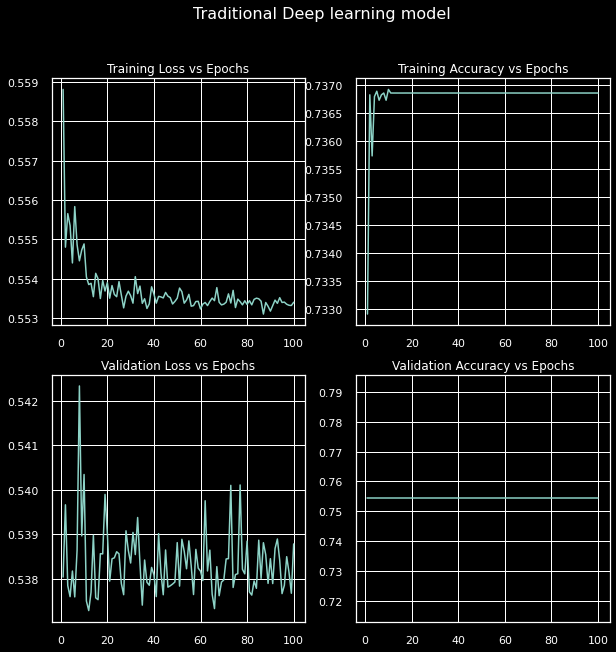

In [216]:
plt.style.use('dark_background')
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 101), y=history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 101), y=history.history.get('accuracy'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 101), y=history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 101), y=history.history.get('val_accuracy'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training Accuracy vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation Accuracy vs Epochs')
plt.suptitle('Traditional Deep learning model',size=16)
plt.show()

LSTM RNN Model

In [250]:
embedding_feature_vectors = 40
model1 = Sequential()
model1.add(Embedding(vocab_size,embedding_feature_vectors,input_length=length))
model1.add(Dropout(0.2))
model1.add(LSTM(200,dropout=0.2,recurrent_dropout=0.3))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model1.add(Dense(3,activation='softmax'))

In [253]:
model1.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

In [254]:
history1 = model1.fit(X_training,y_training,validation_data=(X_valid,y_valid),epochs=10,batch_size=32,verbose=2)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10400 samples, validate on 2600 samples
Epoch 1/10
 - 8s - loss: 0.5045 - accuracy: 0.7664 - val_loss: 0.4493 - val_accuracy: 0.7940
Epoch 2/10
 - 8s - loss: 0.4303 - accuracy: 0.8047 - val_loss: 0.3732 - val_accuracy: 0.8331
Epoch 3/10
 - 8s - loss: 0.3832 - accuracy: 0.8291 - val_loss: 0.3596 - val_accuracy: 0.8379
Epoch 4/10
 - 8s - loss: 0.3523 - accuracy: 0.8460 - val_loss: 0.3375 - val_accuracy: 0.8521
Epoch 5/10
 - 8s - loss: 0.3312 - accuracy: 0.8598 - val_loss: 0.3291 - val_accuracy: 0.8591
Epoch 6/10
 - 7s - loss: 0.3158 - accuracy: 0.8683 - val_loss: 0.3340 - val_accuracy: 0.8571
Epoch 7/10
 - 8s - loss: 0.3035 - accuracy: 0.8757 - val_loss: 0.3335 - val_accuracy: 0.8576
Epoch 8/10
 - 8s - loss: 0.2926 - accuracy: 0.8789 - val_loss: 0.3395 - val_accuracy: 0.8556
Epoch 9/10
 - 8s - loss: 0.2852 - accuracy: 0.8846 - val_loss: 0.3293 - val_accuracy: 0.8579
Epoch 10/10
 - 8s - loss: 0.2764 - accuracy: 0.8875 - val_loss: 0.3334 - val_accuracy: 0.8574


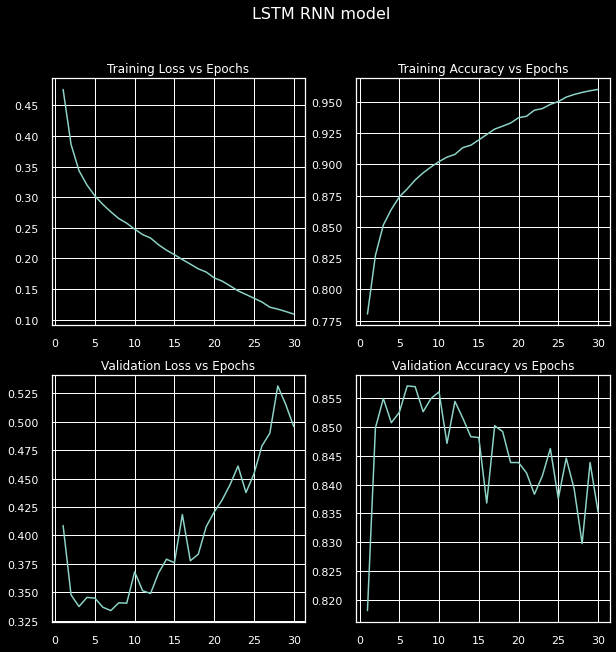

In [245]:
plt.style.use('dark_background')
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 11), y=history1.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 11), y=history1.history.get('accuracy'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 11), y=history1.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 11), y=history1.history.get('val_accuracy'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training Accuracy vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation Accuracy vs Epochs')
plt.suptitle('LSTM RNN model',size=16)
plt.show()

Test accurcy using Traditional DL Model

In [246]:
score_dl = model.evaluate(X_test,y_test)
score_dl

1640/1640 [==============================] - 0s 110us/step


[0.4608333738838754, 0.8378047943115234]

In [247]:
print("Accuracy of Traditional DL model: {}".format(score_dl[1]*100))

Accuracy of Traditional DL model: 83.78047943115234


Test Accuracy of LSTM RNN Model

In [248]:
score_lstm = model1.evaluate(X_test,y_test)
score_lstm

1640/1640 [==============================] - 0s 155us/step


[0.41067658473805685, 0.8678861856460571]

In [249]:
print("Accuracy of LSTM RNN model: {}".format(score_lstm[1]*100))

Accuracy of LSTM RNN model: 86.78861856460571
